In [ ]:
## Load libraries
import os
import pandas as pd

# Import shared helpers and TaxSolver components
from case_helpers import (
    tx, DataLoader, BracketInput,
    BudgetConstraint, IncomeConstraint, MarginalPressureConstraint, BracketConstraint,
    BudgetObjective, GurobiBackend,
    load_simple_simul_data, filter_low_income_households,
)

## Case 1a: Single Tax Rule (outcome_1)

In [ ]:
## Load data for outcome_1
file_path = os.path.join('data', 'simple_simul_1000.xlsx')
df_taxpayers_1 = pd.read_excel(file_path)
df_taxpayers_1['tax'] = df_taxpayers_1['income_before_tax'] - df_taxpayers_1['outcome_1']
df_taxpayers_1['hh_id'] = df_taxpayers_1.index

#### Case 1a: Recover

In [ ]:
dl = DataLoader(path=df_taxpayers_1, income_before_tax="income_before_tax", income_after_tax="outcome_1")

# Initialize the model
tax_solver = tx.TaxSolver(
    dl.households,
    backend=GurobiBackend(), # You can switch to other backends if needed
    )

# Define inflection points for bracket structure
inflection_points = [0, 25_000, 50_000, 75_000, 100_000, 150_000]

BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="income_before_tax",
    inflection_points=inflection_points,
    group_vars=["k_everybody"],
)

# Define rules
income_tax = tx.BracketRule(
    name="income_before_tax_k_everybody",
    var_name="income_before_tax",
    k_group_var="k_everybody",
    ub=1,
    lb=0,
)

tax_solver.add_rules([income_tax])

# Add constraints
income_constraint = IncomeConstraint(0.0000001, dl.households.values()) ## Tight income constraints for recovery
budget_constraint = BudgetConstraint(
    "All_households", dl.households.values(), 1_000, 1_000 ## Tight budget constraint for recovery
)
tax_solver.add_constraints([income_constraint, budget_constraint])

# Add objective
objective = BudgetObjective(budget_constraint) ## Budget object
tax_solver.add_objective(objective)

# Solve the system
tax_solver.solve()

# Get results
r_and_r = tax_solver.rules_and_rates_table()
r_and_r

Directly loading from pd.DataFrame...
Setting 'weight' to 1 as default.
Mirror household were missing for 1000 households: set to own id
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Current tax balance All_households: -19991111
New Maximum: -19990111
New Minimum: -19990111
Going to solve!
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3004 rows, 12 columns and 3502 nonzeros
Model fingerprint: 0x32f0ce40
Model has 5 simple general constraints
  5 INDICATOR
Variable types: 7 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+07]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 2111 rows and 7 columns
Presolve time: 0.00s
Presolved: 893 rows, 5

,rule_name,rule_type,var_name,rate,b,weight
0,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_0_25000,0.099957,1,1
1,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_25000_50000,0.200023,1,1
2,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_50000_75000,0.300000,1,1
3,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_75000_100000,0.399936,1,1
4,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_100000_150000,0.500032,1,1


#### Case 1a: Reform

In [ ]:
dl = DataLoader(path=df_taxpayers_1, income_before_tax="income_before_tax", income_after_tax="outcome_1")

# Initialize the model for reform
tax_solver = tx.TaxSolver(
    dl.households,
    backend=GurobiBackend(),)

# Define inflection points for bracket structure
inflection_points = [0, 25_000, 50_000, 75_000, 100_000, 1_000_000]

BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="income_before_tax",
    inflection_points=inflection_points,
    group_vars=["k_everybody"],
)

# Define rules with rate_lb=0
income_tax = tx.BracketRule(
    name="income_before_tax_k_everybody",
    var_name="income_before_tax",
    k_group_var="k_everybody",
    ub=1,
    lb=0,
)

tax_solver.add_rules([income_tax])

# Add constraints
income_constraint = IncomeConstraint(0.10, dl.households.values())

# Define low income households to target for 5% increase in net income constraint
low_income_households = [
    hh for hh in dl.households.values() 
    if hh.members[0]["income_before_tax"] < 70_000
]
income_constraint_low_income = IncomeConstraint(-0.05, low_income_households)

budget_constraint = BudgetConstraint(
    "All_households", dl.households.values(), 1_000
)

marginal_pressure_constraint = MarginalPressureConstraint(1.0)

tax_solver.add_constraints([
    income_constraint, 
    income_constraint_low_income,
    budget_constraint, 
    marginal_pressure_constraint
])

bracket_constraint = BracketConstraint(
    rule_family="income_before_tax_k_everybody",
    max_brackets=None,
    ascending=True,
    start_from_first_inflection=False,
    last_bracket_zero=False,
)
bracket_constraint.brackets = income_tax.flat_rules
tax_solver.add_constraints([bracket_constraint])

# Add objective
objective = BudgetObjective(budget_constraint)
tax_solver.add_objective(objective)

# Solve the system
tax_solver.solve()

# Get results
r_and_r = tax_solver.rules_and_rates_table()
r_and_r

Directly loading from pd.DataFrame...
Using 'income_after_tax' as the income before tax column.
Mirror household were missing for 1000 households: set to own id
Current tax balance All_households: -19991111
New Maximum: -19990111
Going to solve!
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 4433 rows, 1013 columns and 6388 nonzeros
Model fingerprint: 0xf33f9421
Model has 6 simple general constraints
  1 MAX, 5 INDICATOR
Variable types: 1008 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+07]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 3582 rows and 1008 columns
Presolve time: 0.00s
Presolved: 851 rows, 5 columns, 3244 nonzeros
Variable types: 5 continuous, 0 integer (0 binary)


,rule_name,rule_type,var_name,rate,b,weight
0,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_0_25000,0.054955,1,1
1,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_25000_50000,0.160024,1,1
2,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_50000_75000,0.265000,1,1
3,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_75000_100000,0.640065,1,1
4,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_100000_1000000,0.640065,1,1


## Case 1b: Multiple Tax Rules (outcome_2)

In [ ]:
## Load data for outcome_2
file_path = os.path.join('data', 'simple_simul_1000.xlsx')
df_taxpayers_2 = pd.read_excel(file_path)
df_taxpayers_2['tax'] = df_taxpayers_2['income_before_tax'] - df_taxpayers_2['outcome_2']
df_taxpayers_2['hh_id'] = df_taxpayers_2.index
df_taxpayers_2.rename(columns={"tax_2_children": "sq_a_tax_2_children"}, inplace=True)
df_taxpayers_2["sq_m_tax_2_children"] = 0

#### Case 1b: Recover

In [ ]:
dl = DataLoader(path=df_taxpayers_2, income_before_tax="income_before_tax", income_after_tax="outcome_2")

# Initialize the model
tax_solver = tx.TaxSolver(
    dl.households,
    backend=GurobiBackend(),
    )

# Define inflection points for bracket structure
inflection_points = [0, 25_000, 30_000, 40_000, 50_000, 75_000, 100_000, 150_000]

BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="income_before_tax",
    inflection_points=inflection_points,
    group_vars=["k_everybody"],
)

# Define rules (Bracket, Child benefit, Universal benefit)
income_tax = tx.BracketRule(
    name="income_before_tax_k_everybody",
    var_name="income_before_tax",
    k_group_var="k_everybody",
    ub=1,
    lb=0,
)

child_benefit = tx.BenefitRule(
    name="child_benefit",
    var_name="i_children",
)

universal_benefit = tx.BenefitRule(
    name="universal_benefit",
    var_name="k_everybody",
)

tax_solver.add_rules([income_tax, child_benefit, universal_benefit])

# Add constraints
income_constraint = IncomeConstraint(0.0000001, dl.households.values()) ## Tight income constraints for recovery
budget_constraint = BudgetConstraint(
    "All_households", dl.households.values(), 1_000, 1_000 ## Tight budget constraint for recovery
)

tax_solver.add_constraints([income_constraint, budget_constraint])

# Add objective
objective = BudgetObjective(budget_constraint)
tax_solver.add_objective(objective)

# Solve the system
tax_solver.solve()

# Get results
r_and_r = tax_solver.rules_and_rates_table()
r_and_r

Directly loading from pd.DataFrame...
Setting 'weight' to 1 as default.
Mirror household were missing for 1000 households: set to own id
Current tax balance All_households: -18519479
New Maximum: -18518479
New Minimum: -18518479
Going to solve!
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3004 rows, 20 columns and 6894 nonzeros
Model fingerprint: 0xb68ba3b1
Model has 9 simple general constraints
  9 INDICATOR
Variable types: 11 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+07]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 2003 rows and 11 columns
Presolve time: 0.00s
Presolved: 1001 rows, 9 columns, 6889 nonzeros
Variable types: 9 continuous, 0 integer (0 binary)

Root relaxat

,rule_name,rule_type,var_name,rate,b,weight
0,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_0_25000,0.099500,1,1
1,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_25000_30000,0.201379,1,1
2,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_30000_40000,0.350000,1,1
3,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_40000_50000,0.200020,1,1
4,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_50000_75000,0.300000,1,1
5,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_75000_100000,0.400000,1,1
6,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_100000_150000,0.500000,1,1
7,child_benefit,BenefitRule,i_children,799.999920,1,1
8,universal_benefit,BenefitRule,k_everybody,1495.101839,1,1


#### Case 1b: Reform

In [ ]:
dl = DataLoader(path=df_taxpayers_2, income_before_tax="income_before_tax", income_after_tax="outcome_2")

# Initialize the model for reform
tax_solver = tx.TaxSolver(
    dl.households,
    backend=GurobiBackend(),
    )

# Define inflection points for bracket structure
inflection_points = [0, 25_000, 50_000, 75_000, 100_000, 1_000_000]

BracketInput.add_split_variables_to_solver(
    tx=tax_solver,
    target_var="income_before_tax",
    inflection_points=inflection_points,
    group_vars=["k_everybody"],
)

# Define rules
income_tax = tx.BracketRule(
    name="income_before_tax_k_everybody",
    var_name="income_before_tax",
    k_group_var="k_everybody",
    ub=1,
    lb=0,
)

## Keep existing child benefit fixed
existing_child_benefit = tx.ExistingBenefit(
    name="existing_child_benefit",
    var_name="tax_2_children",
    lb=1,
    ub=1,
    weight=10,
)

universal_benefit = tx.BenefitRule(
    name="universal_benefit",
    var_name="k_everybody",
)

tax_solver.add_rules([income_tax, existing_child_benefit, universal_benefit])

# Add constraints
income_constraint = IncomeConstraint(0.10, dl.households.values())

# Define low income households to target for 5% increase in net income constraint
low_income_households = [
    hh for hh in dl.households.values() 
    if hh.members[0]["income_before_tax"] < 70_000
]
income_constraint_low_income = IncomeConstraint(-0.05, low_income_households)

budget_constraint = BudgetConstraint(
    "All_households", dl.households.values(), 1_000_000
)

marginal_pressure_constraint = MarginalPressureConstraint(0.6)

tax_solver.add_constraints([
    income_constraint, 
    income_constraint_low_income,
    budget_constraint, 
    marginal_pressure_constraint
])

bracket_constraint = BracketConstraint(
    rule_family="income_before_tax_k_everybody",
    max_brackets=None,
    ascending=True,
    start_from_first_inflection=False,
    last_bracket_zero=False,
)
bracket_constraint.brackets = income_tax.flat_rules
tax_solver.add_constraints([bracket_constraint])

# Add objective
objective = BudgetObjective(budget_constraint)
tax_solver.add_objective(objective)

# Solve the system
tax_solver.solve()

# Get results
r_and_r = tax_solver.rules_and_rates_table()
r_and_r

Directly loading from pd.DataFrame...
Using 'income_after_tax' as the income before tax column.
Mirror household were missing for 1000 households: set to own id
Current tax balance All_households: -18519479
New Maximum: -17519479
Going to solve!
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 4433 rows, 1017 columns and 8862 nonzeros
Model fingerprint: 0x3902e047
Model has 9 simple general constraints
  1 MAX, 8 INDICATOR
Variable types: 1010 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 2e+07]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 3428 rows and 1010 columns
Presolve time: 0.00s
Presolved: 1005 rows, 7 columns, 5246 nonzeros
Variable types: 

,rule_name,rule_type,var_name,rate,b,weight
0,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_0_25000,0.054986,1,1
1,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_25000_50000,0.160032,1,1
2,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_50000_75000,0.349642,1,1
3,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_75000_100000,0.600000,1,1
4,income_before_tax_k_everybody__income_before_t...,FlatTaxRule,income_before_tax_k_everybody_100000_1000000,0.600000,1,1
5,existing_child_benefit,ExistingBenefit,sq_a_tax_2_children,1.000000,1,10
6,universal_benefit,BenefitRule,k_everybody,1695.211201,1,1


## Visualization: Combined 2x2 Figure

In [ ]:
# Helper functions and configuration for plots
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Import shared plotting helpers
from case_helpers import euro_format, wrangle_intervals, build_tax_line

# Configuration
Y_TITLE = "Taxes paid (€)"
X_TITLE = "Income before tax (€)"
TICK_FONT_SIZE = 12

# Use RdYlBu colormap colors
cmap = plt.cm.RdYlBu
COLOR_DATA = cmap(0.85)      # Data points (blue)
COLOR_CURRENT = cmap(0.85)   # Current system (blue)
COLOR_REFORM = '#8B0000'     # TaxSolver reform (darkred)

# Jude and Laila colors - yellow for emphasis
JL_COLOR = '#FFB90F'         # Yellow (darkgoldenrod1)
JL_ALPHA = 0.9

# Load taxpayer data (use first 100 for simple visualization)
file_path_plot = os.path.join('data', 'simple_simul_1000.xlsx')
df_taxpayers_plot = pd.read_excel(file_path_plot)
df_taxpayers_plot = df_taxpayers_plot.iloc[0:100, :].copy()
df_taxpayers_plot["tax"] = df_taxpayers_plot["income_before_tax"] - df_taxpayers_plot["outcome_1"]
df_taxpayers_plot["tax_2"] = df_taxpayers_plot["income_before_tax"] - df_taxpayers_plot["outcome_2"]

Loaded 100 taxpayers for visualization


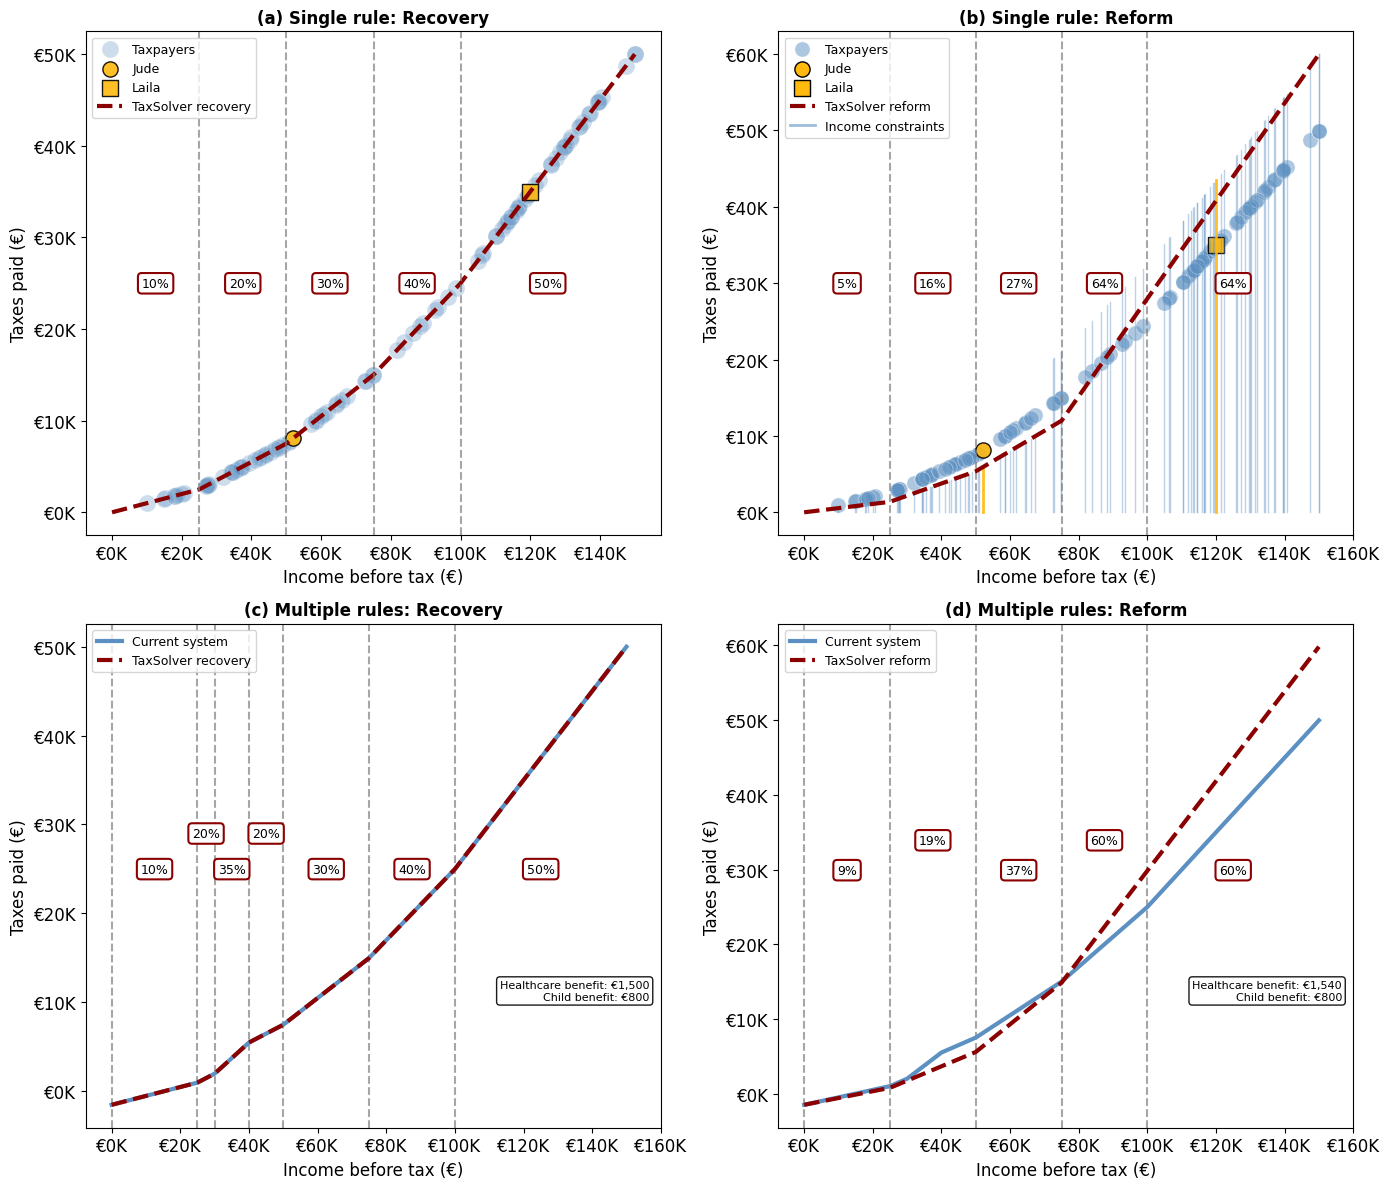

Plot saved to ./output/case_1_combined.png


In [ ]:
# Combined 2x2 Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# TOP ROW: Case 1a (Single Tax Rule with scatter points)

# Calculate income constraint bounds for plot 2
outcome = "outcome_1"
df_taxpayers_plot["tax_ub"] = df_taxpayers_plot.apply(
    lambda row: row["tax"] - 0.05 * row[outcome]
    if row["income_before_tax"] <= 70_000
    else row["tax"] + 0.1 * row[outcome],
    axis=1,
)
df_taxpayers_plot["tax_lb"] = 0

# Load interval data for case 1a
df_intervals_recover_1a = pd.read_excel("./systems_old/case_1_recover.xlsx")
df_intervals_recover_1a = df_intervals_recover_1a.reset_index(drop=True)
df_intervals_recover_1a.iloc[-1, df_intervals_recover_1a.columns.get_loc("bracket_end")] = df_taxpayers_plot["income_before_tax"].max()
x_recover_1a, y_recover_1a, current_y_recover_1a = build_tax_line(df_intervals_recover_1a)

df_intervals_reform_1a = pd.read_excel("./systems_old/case_1_reform_1.xlsx")
df_intervals_reform_1a = df_intervals_reform_1a.reset_index(drop=True)
df_intervals_reform_1a.iloc[-1, df_intervals_reform_1a.columns.get_loc("bracket_end")] = df_taxpayers_plot["income_before_tax"].max()
x_reform_1a, y_reform_1a, current_y_reform_1a = build_tax_line(df_intervals_reform_1a)

# ========== TOP LEFT: Case 1a Recovery ==========
ax1 = axes[0, 0]

# Scatter plot of taxpayers
ax1.scatter(
    df_taxpayers_plot["income_before_tax"],
    df_taxpayers_plot["tax"],
    color=COLOR_DATA,
    alpha=0.3,
    s=150,
    label="Taxpayers",
    edgecolors='white',
    linewidth=0.5
)

# Highlight Jude and Laila
ax1.scatter(df_taxpayers_plot.loc[0, "income_before_tax"], df_taxpayers_plot.loc[0, "tax"],
            color=JL_COLOR, alpha=JL_ALPHA, edgecolor="black", s=120, marker="o")
ax1.scatter(df_taxpayers_plot.loc[1, "income_before_tax"], df_taxpayers_plot.loc[1, "tax"],
            color=JL_COLOR, alpha=JL_ALPHA, edgecolor="black", s=120, marker="s")

# Add legend entries for Jude and Laila
ax1.scatter([], [], color=JL_COLOR, alpha=JL_ALPHA, edgecolor="black", s=120, marker="o", label="Jude")
ax1.scatter([], [], color=JL_COLOR, alpha=JL_ALPHA, edgecolor="black", s=120, marker="s", label="Laila")

# Plot recovered tax schedule
ax1.plot(x_recover_1a, y_recover_1a, label="TaxSolver recovery", color=COLOR_REFORM, linestyle="--", linewidth=3)

# Add vertical lines for bracket boundaries
for income in [25_000, 50_000, 75_000, 100_000]:
    ax1.axvline(x=income, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

# Add rate text boxes
for _, row in df_intervals_recover_1a.iterrows():
    x_mid = (row["bracket_start"] + row["bracket_end"]) / 2
    y_mid = current_y_recover_1a / 2
    rate_text = f"{row['rate']:.0%}"
    ax1.text(x_mid, y_mid, rate_text, fontsize=9, color="black",
            ha="center", va="center",
            bbox=dict(facecolor="white", edgecolor=COLOR_REFORM, linestyle="-", linewidth=1.5, boxstyle="round,pad=0.3"))

ax1.set_xlabel(X_TITLE, fontsize=12)
ax1.set_ylabel(Y_TITLE, fontsize=12)
ax1.xaxis.set_major_formatter(FuncFormatter(euro_format))
ax1.yaxis.set_major_formatter(FuncFormatter(euro_format))
ax1.tick_params(axis='both', labelsize=TICK_FONT_SIZE)
ax1.legend(fontsize=9, loc='upper left')
ax1.set_title("(a) Single rule: Recovery", fontsize=12, fontweight='bold')

# ========== TOP RIGHT: Case 1a Reform ==========
ax2 = axes[0, 1]

# Plot income constraint lines for each taxpayer
for idx, row in df_taxpayers_plot.iterrows():
    color = JL_COLOR if idx in [0, 1] else COLOR_DATA
    alpha = JL_ALPHA if idx in [0, 1] else 0.4
    lw = 2 if idx in [0, 1] else 1
    ax2.plot([row["income_before_tax"], row["income_before_tax"]], [row["tax_lb"], row["tax_ub"]],
             color=color, alpha=alpha, linewidth=lw)

# Scatter plot of taxpayers
ax2.scatter(df_taxpayers_plot["income_before_tax"], df_taxpayers_plot["tax"],
            color=COLOR_DATA, alpha=0.5, s=120, label="Taxpayers", edgecolors='white', linewidth=0.5)

# Highlight Jude and Laila
ax2.scatter(df_taxpayers_plot.loc[0, "income_before_tax"], df_taxpayers_plot.loc[0, "tax"],
            color=JL_COLOR, alpha=JL_ALPHA, edgecolor="black", s=120, marker="o")
ax2.scatter(df_taxpayers_plot.loc[1, "income_before_tax"], df_taxpayers_plot.loc[1, "tax"],
            color=JL_COLOR, alpha=JL_ALPHA, edgecolor="black", s=120, marker="s")

# Add legend entries
ax2.scatter([], [], color=JL_COLOR, edgecolor="black", s=120, marker="o", label="Jude")
ax2.scatter([], [], color=JL_COLOR, edgecolor="black", s=120, marker="s", label="Laila")

# Add vertical lines for bracket boundaries
for income in [25_000, 50_000, 75_000, 100_000]:
    ax2.axvline(x=income, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

# Plot reform line
ax2.plot(x_reform_1a, y_reform_1a, label="TaxSolver reform", color=COLOR_REFORM, linestyle="--", linewidth=3)

# Add rate text boxes
for _, row in df_intervals_reform_1a.iterrows():
    x_mid = (row["bracket_start"] + row["bracket_end"]) / 2
    y_mid = current_y_reform_1a / 2
    rate_text = f"{row['rate']:.0%}"
    ax2.text(x_mid, y_mid, rate_text, fontsize=9, color="black",
            ha="center", va="center",
            bbox=dict(facecolor="white", edgecolor=COLOR_REFORM, linestyle="-", linewidth=1.5, boxstyle="round,pad=0.3"))

# Add legend entry for income constraints
ax2.plot([], [], color=COLOR_DATA, linestyle="-", linewidth=2, label="Income constraints", alpha=0.6)

ax2.set_xlabel(X_TITLE, fontsize=12)
ax2.set_ylabel(Y_TITLE, fontsize=12)
ax2.xaxis.set_major_formatter(FuncFormatter(euro_format))
ax2.yaxis.set_major_formatter(FuncFormatter(euro_format))
ax2.tick_params(axis='both', labelsize=TICK_FONT_SIZE)
ax2.set_xlim(right=160_000)
ax2.legend(fontsize=9, loc='upper left')
ax2.set_title("(b) Single rule: Reform", fontsize=12, fontweight='bold')

# BOTTOM ROW: Case 1b (Multiple Tax Rules with line plots)

# Benefit offset for lines
BENEFIT = 1_500

# Load interval data for case 1b
df_intervals_true = pd.read_excel("./systems_old/case_2_true_income.xlsx")
df_intervals_true = wrangle_intervals(df_intervals_true, df_taxpayers_plot)
x_true, y_true, current_y_true = build_tax_line(df_intervals_true, start_y=0)
y_true = [y - BENEFIT for y in y_true]

df_intervals_recover_1b = pd.read_excel("./systems_old/case_2_recover.xlsx")
df_intervals_recover_1b = wrangle_intervals(df_intervals_recover_1b, df_taxpayers_plot, filter_var="income_before_tax")
x_recover_1b, y_recover_1b, current_y_recover_1b = build_tax_line(df_intervals_recover_1b, start_y=-BENEFIT)

df_intervals_reform_1b = pd.read_excel("./systems_old/case_2_reform_2.xlsx")
df_intervals_reform_1b = wrangle_intervals(df_intervals_reform_1b, df_taxpayers_plot, filter_var="income_before_tax")
x_reform_1b, y_reform_1b, current_y_reform_1b = build_tax_line(df_intervals_reform_1b, start_y=-BENEFIT)

# ========== BOTTOM LEFT: Case 1b Recovery ==========
ax3 = axes[1, 0]

# Add vertical lines for bracket boundaries
for income in [0, 25_000, 30_000, 40_000, 50_000, 75_000, 100_000]:
    ax3.axvline(x=income, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

# Plot lines
ax3.plot(x_true, y_true, label="Current system", color=COLOR_CURRENT, linestyle="-", linewidth=3)
ax3.plot(x_recover_1b, y_recover_1b, label="TaxSolver recovery", color=COLOR_REFORM, linestyle="--", linewidth=3)

# Add rate text boxes for recovery
for i, row in df_intervals_recover_1b.iterrows():
    x_mid = (row["bracket_start"] + row["bracket_end"]) / 2
    y_mid = current_y_recover_1b / 2 + (4000 if i in [1, 3] else 0)
    rate_text = f"{row['rate']:.0%}"
    ax3.text(x_mid, y_mid, rate_text, fontsize=9, color="black",
            ha="center", va="center",
            bbox=dict(facecolor="white", edgecolor=COLOR_REFORM, linestyle="-", linewidth=1.5, boxstyle="round,pad=0.3"))

# Add benefit annotation
ax3.text(0.98, 0.25, "Healthcare benefit: €1,500\nChild benefit: €800", 
         transform=ax3.transAxes, fontsize=8, color="black",
         ha="right", va="bottom",
         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3", alpha=0.9))

ax3.set_xlabel(X_TITLE, fontsize=12)
ax3.set_ylabel(Y_TITLE, fontsize=12)
ax3.xaxis.set_major_formatter(FuncFormatter(euro_format))
ax3.yaxis.set_major_formatter(FuncFormatter(euro_format))
ax3.tick_params(axis='both', labelsize=TICK_FONT_SIZE)
ax3.set_xlim(right=160_000)
ax3.legend(fontsize=9, loc='upper left')
ax3.set_title("(c) Multiple rules: Recovery", fontsize=12, fontweight='bold')

# ========== BOTTOM RIGHT: Case 1b Reform ==========
ax4 = axes[1, 1]

# Add vertical lines for bracket boundaries
for income in [0, 25_000, 50_000, 75_000, 100_000]:
    ax4.axvline(x=income, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

# Plot lines
ax4.plot(x_true, y_true, label="Current system", color=COLOR_CURRENT, linestyle="-", linewidth=3)
ax4.plot(x_reform_1b, y_reform_1b, label="TaxSolver reform", color=COLOR_REFORM, linestyle="--", linewidth=3)

# Add rate text boxes for reform
for i, row in df_intervals_reform_1b.iterrows():
    x_mid = (row["bracket_start"] + row["bracket_end"]) / 2
    y_mid = current_y_reform_1b / 2 + (4000 if i in [1, 3] else 0)
    rate_text = f"{row['rate']:.0%}"
    ax4.text(x_mid, y_mid, rate_text, fontsize=9, color="black",
            ha="center", va="center",
            bbox=dict(facecolor="white", edgecolor=COLOR_REFORM, linestyle="-", linewidth=1.5, boxstyle="round,pad=0.3"))

# Add benefit annotation
ax4.text(0.98, 0.25, "Healthcare benefit: €1,540\nChild benefit: €800", 
         transform=ax4.transAxes, fontsize=8, color="black",
         ha="right", va="bottom",
         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3", alpha=0.9))

ax4.set_xlabel(X_TITLE, fontsize=12)
ax4.set_ylabel(Y_TITLE, fontsize=12)
ax4.xaxis.set_major_formatter(FuncFormatter(euro_format))
ax4.yaxis.set_major_formatter(FuncFormatter(euro_format))
ax4.tick_params(axis='both', labelsize=TICK_FONT_SIZE)
ax4.set_xlim(right=160_000)
ax4.legend(fontsize=9, loc='upper left')
ax4.set_title("(d) Multiple rules: Reform", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()